In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from openpyxl.utils.dataframe import dataframe_to_rows
import os
#import xlwt
from openpyxl import load_workbook
import time
import scipy
import math
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.signal import savgol_filter #Smooth
import ast


In [2]:
cm =1/2.54
def fig_pre_def(fx=8, fy=6,lw=1,dpi = 200):
    cm =1/2.54
    plt.rcParams['figure.dpi'] = dpi
    plt.rc('font', family='Helvetica')         # 自型
    plt.rcParams['axes.linewidth'] = lw     # 設置外框的寬度
    return  plt.figure(figsize=(fx*cm,fy*cm))   
    ax = fig.add_subplot(1, 1, 1)
def fig_post_def(xticks =(None,None),yticks =(None,None), 
                 xlim=(None,None),ylim=(None,None),
                 xlabel = None,ylabel=None,
                 title=None,
                 lg_fs = 6,lb_fs = 10,
                 unit = 1/2.54, SVG = False):
    if xticks[0] != None:
        # Edit the major and minor tick locations 設定格線 不指定將由程式自行設定
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(xticks[0]))    
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(xticks[1]))    
    if yticks[0] != None:
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(yticks[0]))
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(yticks[1]))
    #plt.rc('xtick', labelsize=fontsize)          # X軸數字的文字大小
    #plt.rc('ytick', labelsize=fontsize)          # Y軸數字的文字大小
    ax.tick_params(axis='x', labelsize= lb_fs)
    ax.tick_params(axis='y', labelsize= lb_fs)
    ax.xaxis.set_tick_params(which='major', size=10*unit, width=1, direction='in', top='on')    # x軸主要格線
    ax.xaxis.set_tick_params(which='minor', size=7*unit, width=1, direction='in', top='on')     # x軸次要格線
    ax.yaxis.set_tick_params(which='major', size=10*unit, width=1, direction='in', right='on')   # y軸主要格線
    ax.yaxis.set_tick_params(which='minor', size=7*unit, width=1, direction='in', right='on')   # y軸次要格線
    
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    if xlabel != None:
        ax.set_xlabel(xlabel,fontsize=lb_fs)
    if ylabel != None:
        ax.set_ylabel(ylabel,fontsize=lb_fs)

    if SVG == True:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

        new_rc_params = {'text.usetex': False,
        "svg.fonttype": 'none'
        }
        plt.rcParams['axes.linewidth'] = 1     # 設置外框的寬度
        mpl.rcParams.update(new_rc_params)
    plt.gca().set_position([0, 0, 1, 1])


    plt.legend(fontsize=lg_fs,title=title,title_fontsize=lg_fs,frameon= False)
    plt.rcParams['figure.dpi'] = 80
#cm =1/2.54
#fig = fig_pre_def(6,4.5,1)# 圖片大小
#ax = fig.add_subplot(1, 1, 1)          # 產生1x1格圖片、在第一格
#plt.scatter(x,y, alpha=0.6,linewidth=0,s=30*cm,label=' ')
#plt.plot(x,y     ,'--ob',markersize=8*cm,linewidth=3*cm,mew=0,label='point source')
#fig_post_def()

In [3]:
def sorting(input_data, bin_number , lower_range, upper_range):
    hist, edges = np.histogram( #hist 每格裡面統計的數量 edges:每一格的邊界
    input_data, #要分析的矩陣
    bins=bin_number, 
    range=(lower_range, upper_range), #範圍
    density=False) #是否Normalized成百分比
    Bin_center = []
    for i in range(len(edges)-1):
        Bin_center_single = round((edges[i]+edges[i+1])/2,2)
        Bin_center = np.append(Bin_center,Bin_center_single)
    return Bin_center, hist

In [4]:
Vac_Li_5cm=[]
for i in np.arange(0,32,1):
    if i ==0:
        Vac_Li_5cm = pd.read_csv("../../../data/INER/INER_neutron_source_simulation/output_Li_5cm/202305_p-Li_5cm_E_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
    else:
        Vac_Li_5cm_temp = pd.read_csv("../../../data/INER/INER_neutron_source_simulation/output_Li_5cm/202305_p-Li_5cm_E_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
        Vac_Li_5cm =pd.concat([Vac_Li_5cm,Vac_Li_5cm_temp],axis=0,ignore_index = True)
print(Vac_Li_5cm)       

       particle    energy
0        proton   3.75408
1      deuteron   7.30728
2         alpha  15.41260
3      deuteron   2.78419
4      deuteron  20.79200
...         ...       ...
17021    proton   3.42060
17022  deuteron   7.93475
17023   neutron  12.08590
17024  deuteron  20.51390
17025       Li7   1.83419

[17026 rows x 2 columns]


deuteron    6951
neutron     3927
proton      2727
alpha       2532
Li7          397
triton       314
He3          104
Li6           74
Name: particle, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'deuteron'),
  Text(1, 0, 'neutron'),
  Text(2, 0, 'proton'),
  Text(3, 0, 'alpha'),
  Text(4, 0, 'Li7'),
  Text(5, 0, 'triton'),
  Text(6, 0, 'He3'),
  Text(7, 0, 'Li6')])

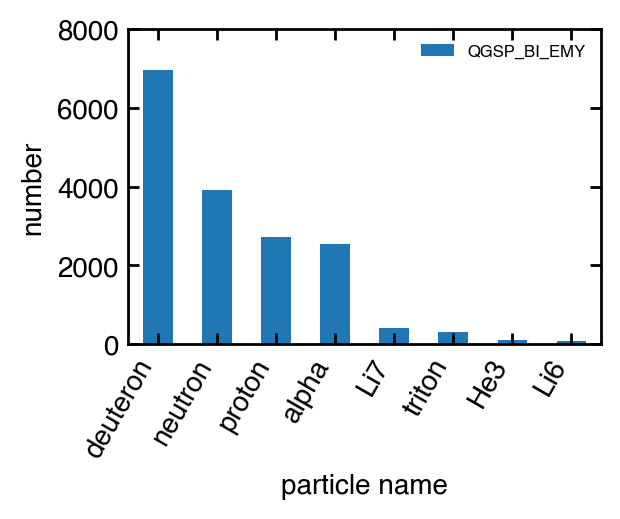

In [5]:
print(Vac_Li_5cm.particle.value_counts())

fig = fig_pre_def(6,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

Vac_Li_5cm.particle.value_counts()[:10].plot(kind='bar',label = 'QGSP_BI_EMY')

fig_post_def(ylim = (0,8000),xlabel = 'particle name',ylabel = 'number')
plt.xticks(rotation=60,ha="right")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      particle     energy
8      neutron  11.636400
10     neutron   1.995470
13     neutron   0.757356
25     neutron   5.305730
31     neutron   7.156860
...        ...        ...
17006  neutron   1.499770
17007  neutron  10.838400
17009  neutron   8.513860
17018  neutron   2.023440
17023  neutron  12.085900

[3927 rows x 2 columns]


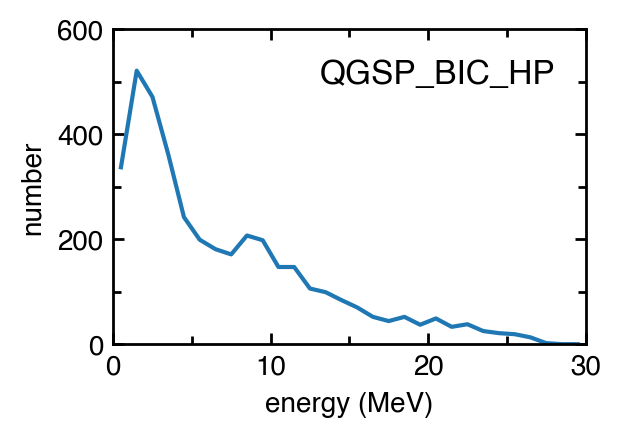

In [16]:
Vac_Li_5cm_neutron_mask = Vac_Li_5cm['particle']=='neutron'
Vac_Li_5cm_n = Vac_Li_5cm[(Vac_Li_5cm_neutron_mask)]
print(Vac_Li_5cm_n)
Vac_Li_5cm_n_x,Vac_Li_5cm_n_y = sorting(Vac_Li_5cm_n['energy'],30,0,30)

fig = fig_pre_def(6,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

plt.plot(Vac_Li_5cm_n_x,Vac_Li_5cm_n_y)

fig_post_def(xlim = (0,30),xticks=(10,5),ylim = (0,600),yticks=(200,100),xlabel = 'energy (MeV)',ylabel = 'number'
             ,lg_fs=12,title='QGSP_BIC_HP')

In [19]:
Air_Li_5cm=[]
for i in np.arange(0,32,1):
    if i ==0:
        Air_Li_5cm = pd.read_csv("../../../data/INER/INER_neutron_source_simulation/output_Li_5cm/202305_p-Li_Air5cm_E_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
    else:
        Air_Li_5cm_temp = pd.read_csv("../../../data/INER/INER_neutron_source_simulation/output_Li_5cm/202305_p-Li_Air5cm_E_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
        Air_Li_5cm =pd.concat([Air_Li_5cm,Air_Li_5cm_temp],axis=0,ignore_index = True)
print(Air_Li_5cm)       

       particle    energy
0        proton  13.44420
1        proton   2.71309
2           He3   9.55440
3        proton   7.80082
4        proton  18.31440
...         ...       ...
29703  deuteron  17.00700
29704   neutron  13.89330
29705  deuteron  20.45070
29706  deuteron  18.04300
29707     alpha   4.14034

[29708 rows x 2 columns]


proton      9402
deuteron    8782
neutron     5484
alpha       2943
C12          859
N14          667
C13          278
triton       240
B10          207
O16          188
N13          159
He3          156
Li7           97
N15           71
O15           64
Li6           55
Be8           28
O14           12
Be7            5
C11            2
O18            2
B11            2
O17            1
K39            1
Ar38           1
Cl36           1
Ar39           1
Name: particle, dtype: int64


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'proton'),
  Text(1, 0, 'deuteron'),
  Text(2, 0, 'neutron'),
  Text(3, 0, 'alpha'),
  Text(4, 0, 'C12'),
  Text(5, 0, 'N14'),
  Text(6, 0, 'C13'),
  Text(7, 0, 'triton'),
  Text(8, 0, 'B10'),
  Text(9, 0, 'O16')])

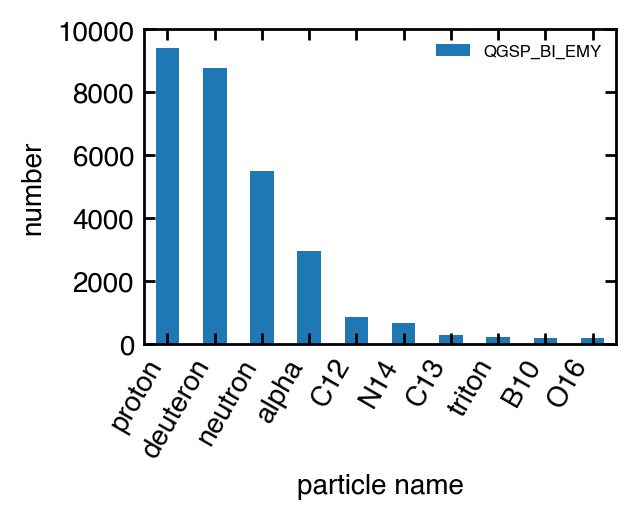

In [21]:
print(Air_Li_5cm.particle.value_counts())

fig = fig_pre_def(6,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

Air_Li_5cm.particle.value_counts()[:10].plot(kind='bar',label = 'QGSP_BI_EMY')

fig_post_def(ylim = (0,10000),xlabel = 'particle name',ylabel = 'number')
plt.xticks(rotation=60,ha="right")

      particle    energy
9      neutron  25.93350
10     neutron   2.16400
13     neutron   1.19764
19     neutron   2.88819
21     neutron  22.50510
...        ...       ...
29665  neutron   1.56797
29674  neutron   0.96057
29678  neutron   7.84904
29701  neutron   4.68338
29704  neutron  13.89330

[5484 rows x 2 columns]


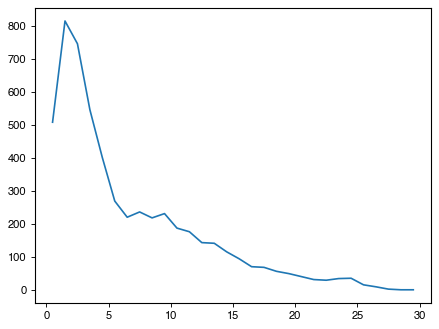

In [22]:
Air_Li_5cm_neutron_mask = Air_Li_5cm['particle']=='neutron'
Air_Li_5cm_n = Air_Li_5cm[(Air_Li_5cm_neutron_mask)]
print(Air_Li_5cm_n)
Air_Li_5cm_n_x,Air_Li_5cm_n_y = sorting(Air_Li_5cm_n['energy'],30,0,30)
plt.plot(Air_Li_5cm_n_x,Air_Li_5cm_n_y)

In [33]:
HEA_QBBC_1um=[]
for i in np.arange(0,32,1):
    if i ==0:
        HEA_QBBC_1um = pd.read_csv("../HEA_data/output_QBBC_EMZ_HEA_1um_Si_525um/202305_secondary_particle_E_QBBC_EMZ_HEA_1um_Si_525um_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
    else:
        HEA_QBBC_1um_temp = pd.read_csv("../HEA_data/output_QBBC_EMZ_HEA_1um_Si_525um/202305_secondary_particle_E_QBBC_EMZ_HEA_1um_Si_525um_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
        HEA_QBBC_1um =pd.concat([HEA_QBBC_1um,HEA_QBBC_1um_temp],axis=0,ignore_index = True)
print(HEA_QBBC_1um)      

        particle    energy
0         proton  10.61280
1        neutron   8.87969
2         proton   6.66564
3         proton  15.81290
4       deuteron  10.61200
...          ...       ...
827536    proton   1.36120
827537  deuteron  14.78400
827538    proton   9.81524
827539    proton   2.43541
827540   neutron   2.58429

[827541 rows x 2 columns]


proton      605744
neutron     121320
deuteron     72046
e-           19624
Al27          2422
Si28          2010
alpha         1905
e+            1436
Si27           329
Mg24           184
triton         173
Si29           140
Si30            54
He3             46
P28             37
Al25            24
P29             11
Al26            10
Mg25             8
Al28             6
P30              5
Mg26             4
Mn51             1
Al29             1
Fe56             1
Name: particle, dtype: int64
proton      605744
neutron     121320
deuteron     72046
e-           19624
Al27          2422
Si28          2010
alpha         1905
e+            1436
Si27           329
Mg24           184
triton         173
Si29           140
Si30            54
He3             46
P28             37
Al25            24
P29             11
Al26            10
Mg25             8
Al28             6
P30              5
Mg26             4
Mn51             1
Al29             1
Fe56             1
Name: particle, dtype

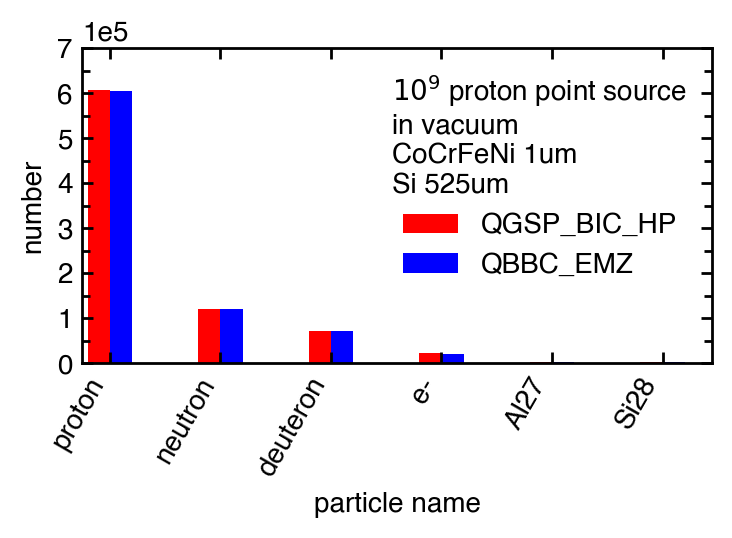

In [42]:
print(HEA_QBBC_1um.particle.value_counts())
print(HEA_QBBC_1um.particle.value_counts())

fig = fig_pre_def(8,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

ind = np.arange(10)
HEA_QGSP_1um.particle.value_counts()[:6].plot(kind='bar',label = 'QGSP_BIC_HP', color='red',alpha =1,align='edge', width=-0.2)
HEA_QBBC_1um.particle.value_counts()[:6].plot(kind='bar',label = 'QBBC_EMZ', color='blue',alpha =1,align='edge', width=0.2)

fig_post_def(ylim = (0,700000),xlabel = 'particle name',yticks=(100000,50000),ylabel = r'number',title='$10^9$ proton point source\nin vacuum\nCoCrFeNi 1um\nSi 525um',lg_fs = 10)
plt.xticks(rotation=60,ha="right")
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

In [29]:
HEA_wo_Co_QBBC_1um=[]
for i in np.arange(0,32,1):
    if i ==0:
        HEA_wo_Co_QBBC_1um = pd.read_csv("../HEA_data/output_QBBC_EMZ_HEA_NCo_1um_Si_525um/202305_secondary_particle_E_QBBC_EMZ_HEA_NCo_1um_Si_525um_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
    else:
        HEA_wo_Co_QBBC_1um_temp = pd.read_csv("../HEA_data/output_QBBC_EMZ_HEA_NCo_1um_Si_525um/202305_secondary_particle_E_QBBC_EMZ_HEA_NCo_1um_Si_525um_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
        HEA_wo_Co_QBBC_1um =pd.concat([HEA_wo_Co_QBBC_1um,HEA_wo_Co_QBBC_1um_temp],axis=0,ignore_index = True)
print(HEA_wo_Co_QBBC_1um)       

        particle    energy
0         proton   4.07278
1       deuteron   9.61698
2       deuteron   3.70930
3         proton  10.69750
4         proton   6.66542
...          ...       ...
827913    proton   4.26877
827914    proton   4.20311
827915    proton  18.79960
827916   neutron   2.38135
827917   neutron   3.58683

[827918 rows x 2 columns]


proton      607278
neutron     120377
deuteron     71624
e-           19635
Al27          2518
Si28          1982
alpha         1971
e+            1486
Si27           334
triton         177
Si29           163
Mg24           159
P28             59
Si30            43
He3             39
Al25            16
Al26            16
Al28            14
Mg25             9
P29              7
Ni57             2
Mn52             2
P30              2
Co55             1
Mn51             1
Al29             1
Mg26             1
Na22             1
Name: particle, dtype: int64
proton      607278
neutron     120377
deuteron     71624
e-           19635
Al27          2518
Si28          1982
alpha         1971
e+            1486
Si27           334
triton         177
Si29           163
Mg24           159
P28             59
Si30            43
He3             39
Al25            16
Al26            16
Al28            14
Mg25             9
P29              7
Ni57             2
Mn52             2
P30              2
Co

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'proton'),
  Text(1, 0, 'neutron'),
  Text(2, 0, 'deuteron'),
  Text(3, 0, 'e-'),
  Text(4, 0, 'Al27'),
  Text(5, 0, 'Si28'),
  Text(6, 0, 'alpha'),
  Text(7, 0, 'e+'),
  Text(8, 0, 'Si27'),
  Text(9, 0, 'triton')])

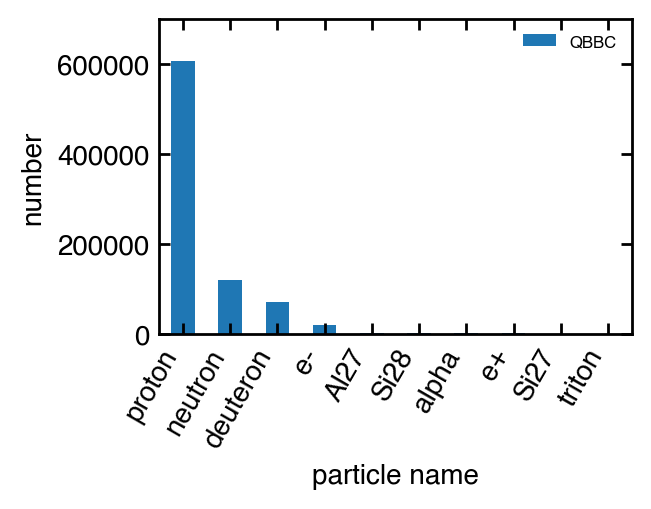

In [31]:
print(HEA_wo_Co_QBBC_1um.particle.value_counts())
print(HEA_wo_Co_QBBC_1um.particle.value_counts())
fig = fig_pre_def(6,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

HEA_wo_Co_QBBC_1um.particle.value_counts()[:10].plot(kind='bar',label = 'QBBC')

fig_post_def(ylim = (0,700000),xlabel = 'particle name',ylabel = 'number')
plt.xticks(rotation=60,ha="right")

In [22]:
HEA_wo_Co_QGSP_1um=[]
for i in np.arange(0,32,1):
    if i ==0:
        HEA_wo_Co_QGSP_1um = pd.read_csv("../HEA_data/output_QGSP_BIC_HP_HEA_NCo_1um_Si_525um/202305_secondary_particle_E_QGSP_BIC_HP_HEA_NCo_1um_Si_525um_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
    else:
        HEA_wo_Co_QGSP_1um_temp = pd.read_csv("../HEA_data/output_QGSP_BIC_HP_HEA_NCo_1um_Si_525um/202305_secondary_particle_E_QGSP_BIC_HP_HEA_NCo_1um_Si_525um_1E9_"+str(int(i))+".txt",delimiter=' ', header=None,names=['particle','energy'])
        HEA_wo_Co_QGSP_1um =pd.concat([HEA_wo_Co_QGSP_1um,HEA_wo_Co_QGSP_1um_temp],axis=0,ignore_index = True)
print(HEA_wo_Co_QGSP_1um)       

       particle    energy
0        proton  13.92170
1       neutron   6.91901
2        proton   3.71297
3        proton  20.93780
4        proton   2.56870
...         ...       ...
830009   proton  16.02060
830010  neutron  11.07710
830011   proton  23.26440
830012   proton   2.51142
830013   proton   5.94040

[830014 rows x 2 columns]


proton      609048
neutron     120165
deuteron     71338
e-           21751
Al27          1981
alpha         1903
e+            1681
Si28          1314
Si27           239
triton         189
Si29           118
Mg24            86
P28             53
He3             51
Si30            27
Al25            18
Mg25            11
Al26             9
Al28             6
P30              5
Cr51             5
P29              5
Co57             3
Al29             1
Fe55             1
Co56             1
Ni59             1
Cr52             1
Mn51             1
Fe56             1
Na22             1
Name: particle, dtype: int64


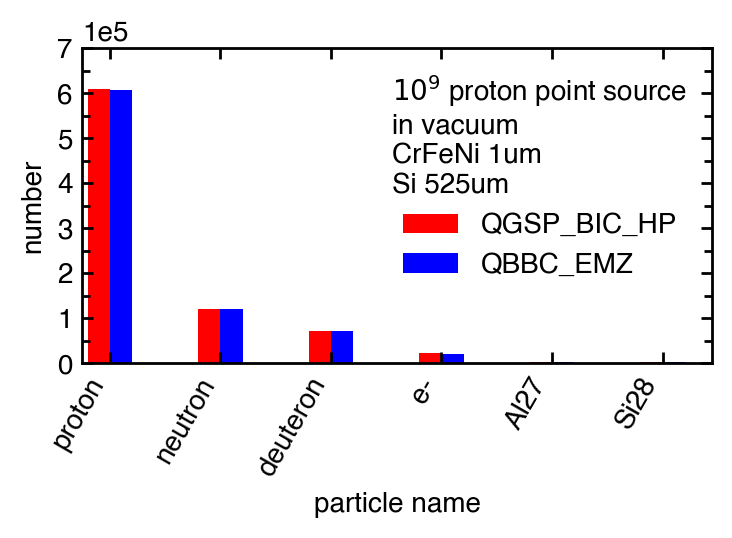

In [41]:
print(HEA_wo_Co_QGSP_1um.particle.value_counts())

fig = fig_pre_def(8,4)# 圖片大小
ax = fig.add_subplot(1, 1, 1) 

ind = np.arange(10)
HEA_wo_Co_QGSP_1um.particle.value_counts()[:6].plot(kind='bar',label = 'QGSP_BIC_HP', color='red',alpha =1,align='edge', width=-0.2)
HEA_wo_Co_QBBC_1um.particle.value_counts()[:6].plot(kind='bar',label = 'QBBC_EMZ', color='blue',alpha =1,align='edge', width=0.2)

fig_post_def(ylim = (0,700000),xlabel = 'particle name',yticks=(100000,50000),ylabel = r'number',title='$10^9$ proton point source\nin vacuum\nCrFeNi 1um\nSi 525um',lg_fs = 10)
plt.xticks(rotation=60,ha="right")
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

In [ ]:
freq = HEA_QBBC_1um['particle'].value_counts()
print(freq)

In [ ]:
plt.hist(HEA_QBBC_1um['energy'],range=(0,30),bins=300)

In [ ]:
mask = HEA_QBBC_10um['particle'] == 'Mn52[377.749]'

ft_data = HEA_QBBC_10um[mask]
print(ft_data)


In [ ]:
mask_n = HEA_QBBC_1um['particle']=='neutron'
HEA_QBBC_1um_neutron = HEA_QBBC_1um[mask_n]
print(HEA_QBBC_1um_neutron)


In [ ]:
globals()["data_"+str(int(i))+"MeV"] = pd.DataFrame(globals()["data_"+str(int(i))+"MeV"],columns=["core","counts","Tri_LO","Tri_pE","Rec_nE","Rec_LO"])
